In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib import colormaps

from b3d.io import FeatureTrackData, get_shared
from b3d.utils import keysplit, downsize_images
from b3d.camera import Intrinsics

def rgb_for_uv_from_img(uvs, img_rgb):
    ji = jnp.floor(uvs).astype(jnp.int32)
    return img_rgb[ji[..., 1], ji[..., 0], :]


In [3]:
import rerun as rr

In [4]:
from sklearn.utils import Bunch


In [5]:
from sklearn.utils import Bunch


def create_box_mesh(dims=np.array([1.,1.,1.])):

    # Define the 8 vertices of the box
    w, h, d = dims/2.
    vertex_positions = np.array([
        [-w, -h, -d],
        [ w, -h, -d],
        [ w,  h, -d],
        [-w,  h, -d],
        [-w, -h,  d],
        [ w, -h,  d],
        [ w,  h,  d],
        [-w,  h,  d],
    ])

    # Define the 12 triangles (two per face)
    triangle_indices = np.array([
        [0, 1, 2], [0, 2, 3],  # Front face
        [4, 5, 6], [4, 6, 7],  # Back face
        [0, 1, 5], [0, 5, 4],  # Bottom face
        [2, 3, 7], [2, 7, 6],  # Top face
        [0, 3, 7], [0, 7, 4],  # Left face
        [1, 2, 6], [1, 6, 5],  # Right face
    ])
    vertex_normals = vertex_positions

    return vertex_positions, triangle_indices, vertex_normals


def create_pose_bunch(p, c=jnp.array([.7,.7,.7]), s=1.0, dims=np.array([.2, .2, 1.])):
    vs, fs, ns = create_box_mesh(dims=s*dims)

    if c is None: c = jnp.array([.7,.7,.7])
    cs = c[None, :] * jnp.ones((vs.shape[0], 1))

    return Bunch(
        vertex_positions = p(vs),
        triangle_indices = fs,
        vertex_normals = p.rot.apply(ns),
        vertex_colors = cs,
    )

def log_pose(s, p, c=jnp.array([.7,.7,.7]), scale=1., dims=np.array([.2,.2,1.])):
    rr.log(s, rr.Mesh3D(
            **create_pose_bunch(p, c=c, s=scale, dims=dims),
            # mesh_material=rr.components.Material(albedo_factor=[255, 255, 255]),
    ))




# Load Raw Data

In [7]:
import os
import jax.numpy as jnp
from b3d.io import FeatureTrackData, get_shared
from b3d.utils import downsize_images
from b3d.camera import Intrinsics
import numpy as np




In [8]:
path = get_shared()/"dynamic_SfM/feature_track_data/"

print(f"{path}:")
files = os.listdir(path)
for i, f in enumerate(files):
    print(f" - ({i}) \033[1m{f}\033[0m")

/home/mirko/workspace/b3d/assets/shared_data_bucket/dynamic_SfM/feature_track_data:
 - (0) grab_box_2_pixel4a.FeatureTrackData.npz
 - (1) plantRoomLookingThrough_30fps_lit_bg_800p.input.npz
 - (2) plantRoomLookingThrough_30fps_lit_bg_800p.input.npz_.gstmp
 - (3) slidingBooks_60fps_lit_bg_800p.input.npz_.gstmp
 - (4) slidingPiledBooks_60fps_lit_bg_800p.input.npz
 - (5) grab_box_1_pixel4a.FeatureTrackData.npz
 - (6) grab_box_2_pixel4a.FeatureTrackData.npz_.gstmp
 - (7) slidingBooks_60fps_lit_bg_800p.input.npz
 - (8) slidingPiledBooks_60fps_lit_bg_800p.input.npz_.gstmp



FeatureTrackData:
    Num Frames: 271
    Num Keypoints: 8823
    Image shape (width x height): 800 x 800
    FPS: None

Intrinsics(width=Array(800, dtype=int32), height=Array(800, dtype=int32), fx=Array(466.66666, dtype=float32), fy=Array(466.66666, dtype=float32), cx=Array(400., dtype=float32), cy=Array(400., dtype=float32), near=Array(0.01, dtype=float32), far=Array(10., dtype=float32))


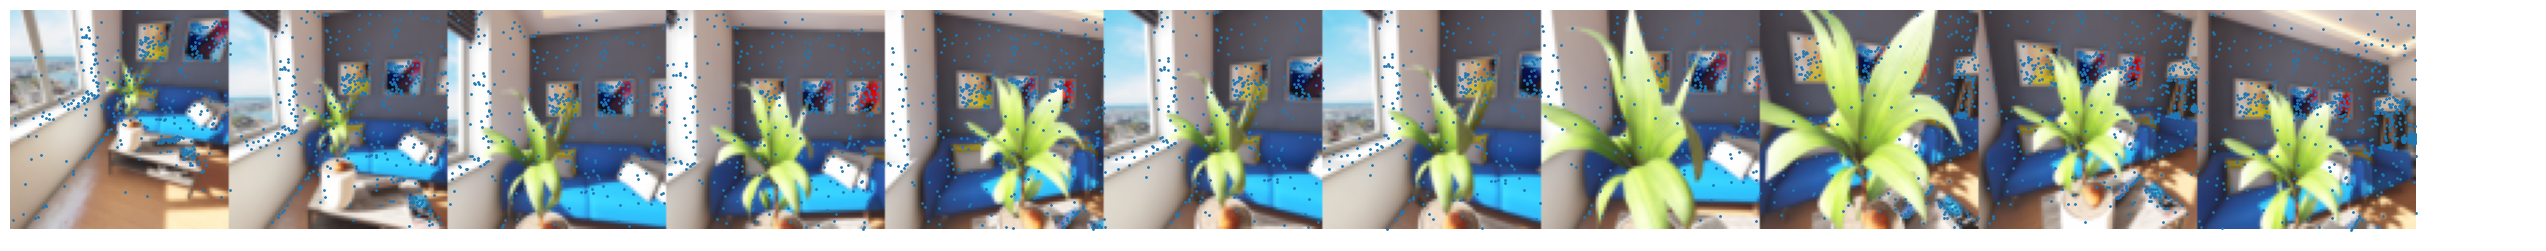

In [9]:
fname = path/files[1]
data = FeatureTrackData.load(fname)

_T = data.shape[0]
_N = data.shape[1]
_uvs = data.uv
_vis = data.vis
_rgb = data.rgb_uint
_intr = Intrinsics.from_array(data.camera_intrinsics)

print(data)
print(_intr)

_downsize = 10
_rgb_small = downsize_images(_rgb, _downsize)

data[::len(data)//10].quick_plot(downsize=10)

## Pick frames for inference task

In [10]:
print(data.num_frames)

271



    417
    437
    353
    204



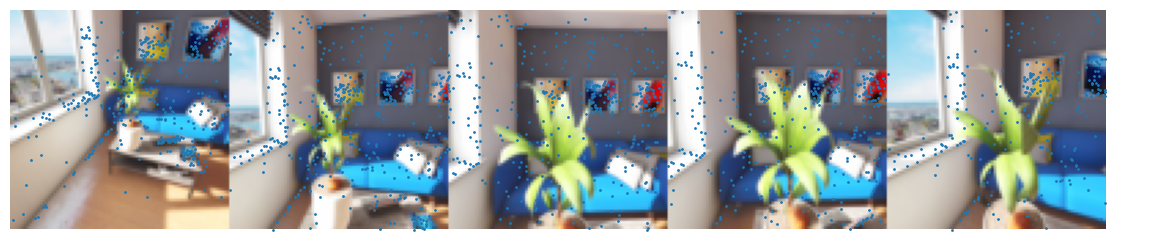

In [12]:
t0 = 0
t1 = 40
t2 = 80
t2 = 120

ts = jnp.array([0,40,80,120, 160])

print(f"""
    {_vis[t0].sum()}
    {_vis[t1].sum()}
    {_vis[t2].sum()}
    {(_vis[t0]*_vis[t1]*_vis[t2]).sum()}
""")


# ==========================
data[ts].quick_plot(downsize=10, figsize=(3,3))

In [13]:
data[ts].save("_testdata.npz")

In [14]:
del data

# Load data

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from b3d.io import FeatureTrackData, get_shared

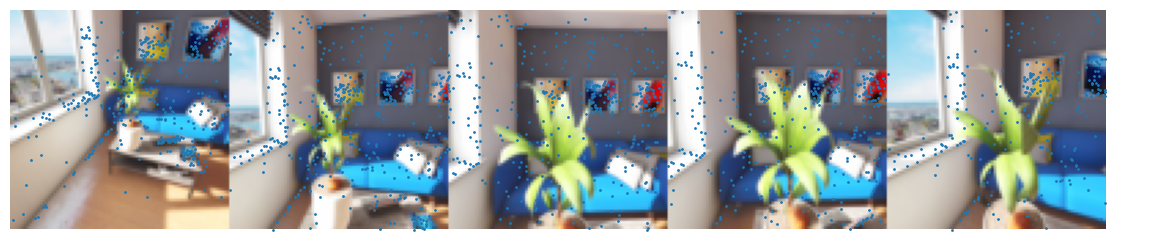

In [7]:
data = FeatureTrackData.load("_testdata.npz")
data.quick_plot(downsize=10, figsize=(3,3))

In [8]:
vis_in_any = data.vis.sum(0) > 0

ps_true = data.camera_poses
xs_true = data.camera_poses[0].inv()(data.latent_keypoint_positions[0])
ps_true = ps_true[0].inv() @ ps_true
cams = ps_true

In [9]:
intr = Intrinsics.from_array(data.camera_intrinsics)

xs_true = xs_true[vis_in_any]
ys  = data.uv[:, vis_in_any]
vis = data.vis[:, vis_in_any]

ys.shape, vis.shape

((5, 597, 2), (5, 597))

(597, 3)
0.99999994


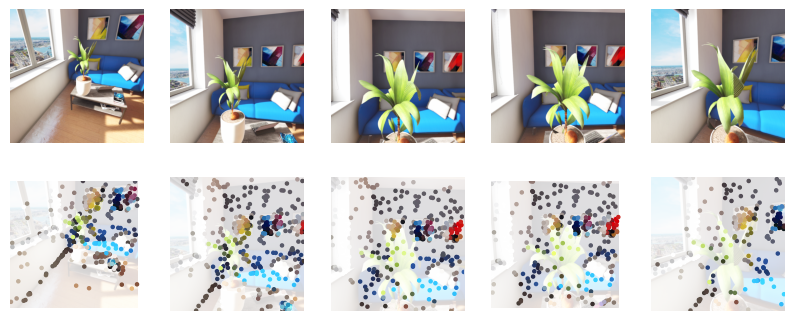

In [10]:
cc = jnp.stack([
    rgb_for_uv_from_img(data.uv[t], data.rgb_uint[t])/255 for t in range(data.num_frames)
], axis=0)

vv = jnp.stack([
    data.vis[t].astype(jnp.float32) for t in range(data.num_frames)
], axis=0)

ww = vv/vv.sum(0)
cols = (cc*ww[:,:,None]).sum(0)
cols = cols[vis_in_any]

print(cols.shape)
print(cols.max())

# # ============================
fig, axs = plt.subplots(2,data.num_frames, figsize=(data.num_frames*2,4))
for t in range(data.num_frames):
    axs[0,t].axis("off")
    axs[1,t].axis("off")
    axs[0,t].imshow(data.rgb_float[t], alpha=1.)
    axs[1,t].imshow(data.rgb_float[t], alpha=.2)

    axs[1,t].scatter(*ys[t, vis[t]].T, c=cols[vis[t]],s=5)



In [11]:
del data;

# Math



## Generative Model

$$
\begin{darray}{rcl}
    p(y, x, c) 
    &=& P(y \mid c, x) \ P(x) \ P(c) 
    \\
    \\ &=&  \prod_{t,i} P(y_{t,i} \mid c_t, x_i) \cdot \prod_{i} P(x_i) \cdot \prod_t P(c_t).
\end{darray}
$$

**Log score:**

$$
\begin{darray}{rcl}
    \log p(y, x, c) &=& \sum_{t,i} \log P(y_{t,i} \mid c_t, x_i) + \sum_i \log P(x_i)  + \sum_{t} \ \log P(c_t) 
\end{darray}
$$



## Observation Model

$$
\begin{darray}{rcl}
    P(y \mid c, x)
        &=&  \prod_{t,i} P(y_{t,i} \mid c_t, x_i)
        \\
        \\ &=&  \prod_{t,i} \ell_{t,i}.
\end{darray}
$$

**Log score:**

$$
\begin{darray}{rcl}
    \log p(y \mid x, c) &=& \sum_{t,i} \log P(y_{t,i} \mid c_t, x_i)
            \\
        \\ &=&  \sum_{t,i} \log \ell_{t,i}.
\end{darray}
$$




## Map Posterior

**Plain Version:**
$$
\begin{darray}{rcl}
    P(x \mid y_{:t}, c_{:t}) 
    &=& \tfrac{1}{P(y,c)} \ P(x, y, c)
    \\
    \\
    &\propto& P(x, y, c)
    \\
    \\
    &=& P(y \mid c, x) \ P(x) \ P(c) 
    \\
    \\
    &\propto& P(y_{:t} \mid x, c_{:t}) \ P(x)
    \\ 
    \\ &=& \prod_i P(y_{:t,i} \mid x_i, c_{:t}) \ P(x_i)
    \\ 
    \\ &=& \prod_{t,i} P(y_{:t,i} \mid x_i, c_{:t}) \cdot \prod_i P(x_i)
\end{darray}
$$

**Log score:**

NOTE this is an log-proportional score, from the identity above.
$$
\begin{darray}{rcl}
    \log P(x \mid y_{:t}, c_{:t})  &\propto& \sum_{t,i} \log P(y_{:t,i} \mid x_i, c_{:t}) + \sum_i \log P(x_i)
\end{darray}
$$



### Recursive Version
$$
\begin{darray}{rcl}
    P_t (x) := P(x \mid y_{:t}, c_{:t}) 
        &\propto& P(y_{t} \mid x, c_{t}) \ P(x \mid y_{:t-1}, c_{:t-1})
        \\ \\ &=& P(y_{t} \mid x, c_{t}) \ P_{t-1}(x)
        \\ \\ &=&  \prod_i  P( y_{t,i} \mid x_i, c_{t}) \ P(x_i \mid y_{:t-1,i}, c_{:t-1})
        \\ \\ &=&  \prod_i  \ell_{t,i} \ P_{t,i}(x_i)
\end{darray}
$$

That means if we have a particle approximation $\{ (w^{t-1}_{ij}, x_{ij})\}_{I,J}$ of $P_{t-1}(x)$ we get a particle approximation of $P_t(x)$ by updating the weights by $w^t_{ij} =  P(y_{t} \mid x, c_{t}) \cdot w^{t-1}_{ij}$

**Approximating $P(x_i \mid y_{:t,i}, c_{:t})$ using SIR**

Target: 
- $P(x_i \mid y_{:t,i}, c_{:t}) \ \propto \ P( x_i, y_{:t,i},c_{:t}) \propto \ \prod_t P(y_{:t,i} \mid x_i, c_{:t}) \cdot P(x_i) $


Simple Proposal Candidates: 
- Prior: $P(x_i)$
- Particle Posterior based on singe time step: $Q_{ti} = P(x_i \mid y_{t,i}, c_t)$
 
Sample $x_{i1}, \ldots, x_{im}$ and resample w.r.t. $w_j = \tfrac{\widetilde w_j}{\sum_j \widetilde w_j}$, where $\widetilde w_j = \tfrac{ \prod_t P(y_{:t,ij} \mid x_{ij}, c_{:t}) \cdot P(x_{ij})}{Q(x_{ij})} = \prod_t P(y_{:t,ij} \mid x_{ij}, c_{:t}) \cdot \tfrac{P(x_{ij})}{Q(x_{ij})}$.




## Camera Posterior

$$
\begin{darray}{rcl}
  P(c \mid y) 
    &\propto& P(c) \ P(y \mid c)
    \\ &=& 
      P(c) \int P(y \mid c, x) \ P(x) \ dx 
    \\ &=& 
      P(c) \int P(y \mid c, x) \ \tfrac{P(x)}{Q(x)} \ Q(x) \ dx
    \\ &=& 
      P(c) \int \prod_i P(y_i \mid c, x_i) \ \tfrac{P(x_i)}{Q(x_i)} \ Q(x_i) \ dx_1\ldots dx_n
    \\ &\stackrel{\tiny\text{(Fubini)}}{=}& 
      P(c) \prod_i \int P(y_i \mid c, x_i) \ \tfrac{P(x_i)}{Q(x_i)} \ Q(x_i) \ dx_i
    \\
    \\ &\stackrel{\tiny\text{(MC Approx.)}}{\approx}& 
      P(c) \prod_i \tfrac{1}{S} \sum_j \ P(y_{ij} \mid c, x_{ij}) \ \tfrac{P(x_{ij})}{Q(x_{ij})}
    \\ &=& 
      P(c) \prod_i \tfrac{1}{S} \sum_j \ \prod_t P(y_{t,ij} \mid c_t, x_{ij}) \cdot \tfrac{P(x_{ij})}{Q(x_{ij})}
    \\ &=& 
      P(c) \prod_i \tfrac{1}{S} \sum_j \ \tfrac{P(x_{ij})}{Q(x_{ij})} \cdot \prod_t P(y_{t,ij} \mid c_t, x_{ij})
    \\ &=& 
      P(c) \prod_i \tfrac{1}{S} \sum_j \ w_{ij} \cdot \prod_t \ell_{t,ij}
    \\ &=& 
      P(c) \tfrac{1}{S^n} \prod_i \Big( \sum_j \ w_{ij} \cdot \prod_t \ell_{t,ij} \Big)
    \\ &=& 
      P(c) \tfrac{1}{S^n} \prod_i \Big( \sum_j \ w_{ij} \cdot \ell_{ij} \Big)
\end{darray}
$$

Here the $x_{i1},\ldots,x_{iS}  \sim Q_i$ are samples from the $i$'th particle proposal. Note that We can assume $Q(x) = Q( x \mid y, c )$ and use the posterior over particle positions $P(x \mid y, c)$ or some approximation. That means we can write $P(c \mid y)$ as a function of $y$ and a collection of weighted particle posterior samples $\big\{ (w_{ij}, x_{ij}) \big\}_{I\times J}$.

An easier choice for $Q_i(x_i)$ would be a mixture of the form  $\sum_t P(t) \cdot P(x_i \mid y_i, c_t)$

Sampling efficiency is not a huge problem &mdash; althought the space of particles is of dimension $3n$. Note that we actually have ([Fubini](https://en.wikipedia.org/wiki/Fubini%27s_theorem))
$$
  \int \prod_i P(y_i \mid c, x_i) \ P(x_i) \ dx  \stackrel{!}{=}   \ \prod_i \int P(y_i \mid c, x_i) \ P(x_i) \  dx_i.
$$

**Approximate log score:**

Given a collection of weighted particle (posterior) samples $\big\{ (w_{ij}, x_{ij}) \big\}_{I\times J}$ we can compute an approximate log score as follows:
$$
\log P(c \mid y) \stackrel{\propto}{\approx} \log P(c) - N\log S + \sum_i \ \log \sum_j \exp \Big( \log w_{ij} + \sum_t \log \ell_{t,ij}  \Big).
$$



### Camera Posterior &mdash; Single Cam

$$
\begin{darray}{rcl}
  P( c_{:t} \mid y_{:t}) = P( c_t \mid y_{:t}, c_{:t-1} ) \ P(c_{:t-1} \mid y_{:t})
\end{darray}
$$

$$
\begin{darray}{rcl}
  P( c_t \mid y_{:t}, c_{:t-1} ) 
    &\propto& P( y_t \mid c_t, y_{:t-1}, c_{:t-1}) \cdot P( c_t \mid y_{:t-1}, c_{:t-1})
    \\
    \\
    &=& \int P( y_t, x \mid c_t, y_{:t-1}, c_{:t-1}) \ dx \cdot P( c_t \mid y_{:t-1}, c_{:t-1})
    \\
    \\
    &=& \int P( y_t \mid x, c_t) \ P(x \mid  y_{:t-1}, c_{:t-1}) \ dx \cdot P( c_t \mid y_{:t-1}, c_{:t-1})
\end{darray}
$$

In [12]:
import matplotlib.pyplot as plt

In [13]:
from b3d.pose import Pose

# Rotation Matrix for a camera that
# points along the y-axis.
CAM_ALONG_Y = jnp.array([
    [1,0,0],
    [0,0,1],
    [0,-1,0]
])

# Fixed universal camera
_cam0 = Pose.from_pos_matrix(jnp.array([0., -4., 0.]), CAM_ALONG_Y)

In [14]:
import jax
import jax.numpy as jnp
import genjax
from genjax import Pytree
from genjax import ChoiceMapBuilder as C
# from genjax import Target, smc
# from genjax._src.core.generative.choice_map import EmptyChm
# from b3d.pose import Pose, uniform_pose_in_ball
# from b3d.camera import (
#     screen_from_world,
#     camera_from_screen_and_depth,
# )
from b3d.utils import keysplit


key = jax.random.PRNGKey(0)

In [15]:
from jax.scipy.special import logsumexp

In [16]:
rr.init("SfM")
rr.connect("127.0.0.1:8812")

rr.set_time_sequence("frame_idx", 0)
rr.log("Particle_Positions_TRUE", rr.Points3D(
        _cam0(xs_true), 
        colors=cols,
        radii=0.05))

for t in range(cams.shape[0]):
    log_pose(f"Pose_TRUE/Pose[{t}]_TRUE", _cam0@cams[t], 
        c=jnp.array([1.,.0,1.]), 
        scale=.5, dims=np.array([.2,.2,.5]))

# Posteriors

In [16]:
from genjax import SelectionBuilder as SB
from genjax import ChoiceMapBuilder as CMB
from b3d.chisight.sfm.inference.forbidden_scores import (
    single_observation_score,
    single_observation_score_step_fn,
)
from b3d.chisight.sfm.inference.particle_inference import (
    cylinder_particle_proposal,
    SingleParticleProposal,
)
from b3d.utils import keysplit
from b3d.camera import camera_from_screen_and_depth
from jax.scipy.stats.norm import logpdf as normal_logpdf


key = jax.random.PRNGKey(0)
T,N = ys.shape[:2]

In [17]:
# particle_proposal = SingleParticleProposal()
particle_proposal = cylinder_particle_proposal

# NOTE: ok for now
def _weighted_particle_proposal(key, mask,  S, ys, cams, intr, prop_sig):
    N = ys.shape[1]

    tt = jnp.argmax(mask, axis=0)
    ii = jnp.arange(N)

    key = jax.random.split(key)[1]
    keys = jax.random.split(key, N*S).reshape((N,S,2))

    func = lambda key, t, i: particle_proposal.weighted_sample(key, ys[t,i], cams[t], intr, prop_sig)
    
    proposal_ws, proposed_xs = jax.vmap(jax.vmap(func, (0,None,None)), out_axes=1)(keys, tt, ii)

    return proposal_ws, proposed_xs

weighted_particle_proposal =jax.jit(_weighted_particle_proposal, static_argnums=(2,))

In [18]:
def check_weights(ws):
    print(f"""
     inf {(ws ==  jnp.inf).sum()}
    -inf {(ws == -jnp.inf).sum()}
     nan {jnp.isnan(ws).sum()}
    """)

In [19]:
single_observation_score_fn = single_observation_score
# single_observation_score_fn = single_observation_score_step_fn
# single_observation_score_fn = single_observation_score_variable_noise

def observation_score_over_i(mask_i, ys_i, xs_i, cam, intr, sig):
    ws_ = jax.vmap(single_observation_score_fn, (0, 0, None, None, None))(ys_i, xs_i, cam, intr, sig)
    ws = jnp.where(mask_i, ws_, 0.0)
    return ws


observation_scores_over_si = jax.jit(jax.vmap(observation_score_over_i, (None,None,0,None,None,None)))


def observation_scores_over_ti(mask_ti, ys_ti, xs_i, cams_t, intr, sig):
    ws = jax.vmap(observation_score_over_i, (0,0,None,0,None,None))(mask_ti, ys_ti, xs_i, cams_t, intr, sig)
    return ws


observation_scores_over_sti = jax.jit(jax.vmap(observation_scores_over_ti, (None,None,0,None,None,None)))

In [20]:
def single_camera_score_approx(cam, ys_t, ws, xs, intr, sig, mask_i):
    observation_ws = observation_scores_over_si(mask_i, ys_t, xs, cam, intr, sig)
    
    camera_ws = observation_ws + ws
    camera_ws = jnp.where(mask_i[None], camera_ws, 0.0 )

    return (logsumexp(camera_ws, axis=0)).sum()


camera_score_approx = jax.jit(jax.vmap(single_camera_score_approx, 
                                       (0,None,None,None,None,None,None)))


# Exp

# Debugging

In [27]:
from b3d.pose import uniform_pose_in_ball
vmap_uniform_pose = jax.jit(jax.vmap(uniform_pose_in_ball.sample, (0,None,None,None)))

In [28]:
(vis[0]*vis[2]).sum()

Array(203, dtype=int32)

In [29]:
S = 100

prop_sig = jnp.array(.05)
obs_sig  = jnp.array(1.)

t0 = 0

proposal_mask = vis.at[jnp.arange(T)!=t0].set(False)
key = keysplit(key)

intr_ = Intrinsics(*intr[:-2], .1,4.)
# intr_ = intr
proposal_ws, proposed_xs = weighted_particle_proposal(
    key, proposal_mask, S, ys, cams, intr_, prop_sig);

target_scores = observation_scores_over_sti(
    proposal_mask, ys, proposed_xs, cams, intr_, obs_sig);

posterior_ws = target_scores.sum(1) - proposal_ws


# Resample
R = 100
winners = jax.random.categorical(key, posterior_ws, axis=0, shape=(R,N))


mask = proposal_mask.sum(0) > 0

rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)

rr.log("Particle_Proposals_Resampled", rr.Points3D(
        _cam0(proposed_xs[winners, jnp.arange(N)][:,mask].reshape(-1,3)), 
        colors=jnp.tile(cols[None,mask], (R,1)).reshape(-1,3),
        radii=0.02))

In [30]:
proposal_mask.sum(1)

Array([417,   0,   0,   0,   0], dtype=int32)

In [31]:
def quat_diff(q0, q1):
    return jnp.minimum(
        jnp.linalg.norm(  q0 - q1), 
        jnp.linalg.norm(- q0 - q1))

In [77]:

t1 = 1
seed_cam = cams[t1]

In [85]:

def get_sample(key, t1, inferred_cam):
    key, keys = keysplit(key, 1, 1_000)

    test_cams = vmap_uniform_pose(keys, inferred_cam, 0.5, .05)

    obs_sig = jnp.array(.001)


    camera_mask = proposal_mask.any(0) & vis[t1]
    ws = camera_score_approx(test_cams, ys[t1], posterior_ws, proposed_xs, intr, obs_sig, camera_mask)

    i = jax.random.categorical(key, ws)
    # i = jnp.argmax(ws)
    return test_cams[i], ws[i], test_cams[0]

get_samples = jax.jit(jax.vmap(get_sample, (0,None,None)))



ps_ = []
ws_ = []
ps_null_ = []
for _ in range(40):
    key, keys=keysplit(key, 1, 10)
    ps, ws, ps_null = get_samples(keys, t1, seed_cam)
    ps_null_.append(ps_null)
    ps_.append(ps)
    ws_.append(ws)

ws = ws_[0]
ps = ps_[0]
ps_null = ps_null_[0]
for p,w,p0 in zip(ps_[1:], ws_[1:], ps_null_[1:]):
    ps = ps.concat(p)
    ps_null = ps_null.concat(p0)
    ws = jnp.concatenate([ws, w])

seed_cam = ps[jnp.argmax(ws)]
# seed_cam = Pose(seed_cam.pos, ps[jnp.argmax(ws)].quat)

In [86]:
def get_xq_errs(ps, p_target):

    q_ds = jax.vmap(quat_diff, (0,None))(ps.quat, p_target.quat)
    x_ds = jnp.linalg.norm(ps.pos - p_target.pos[None], axis=-1)
    
    
    return x_ds, q_ds

In [87]:
a = cams[t0].pos
b = cams[t1].pos
ambi = (b-a)/jnp.linalg.norm(b-a)



xx = ps.pos - a[None]
xx = xx - jax.vmap(lambda x: jnp.dot(x, ambi)*ambi)(xx)
dd = jnp.linalg.norm(xx, axis=-1)



xx_null = ps_null.pos - a[None]
xx_null = xx_null - ambi[None]*(xx_null*ambi[None]).sum(1)[:,None]
dd_null = jnp.linalg.norm(xx_null, axis=-1)

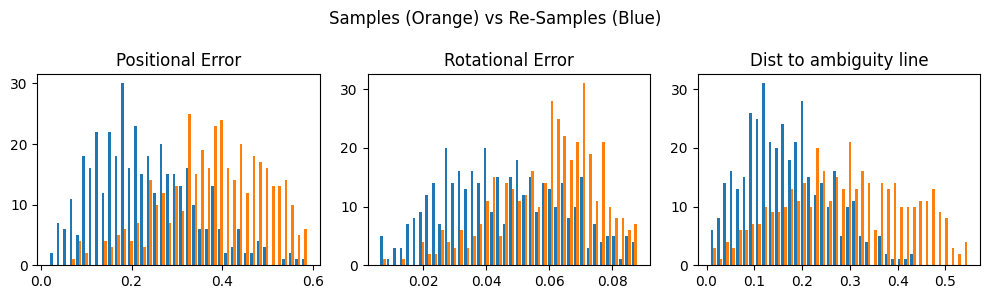

In [88]:
fig, axs = plt.subplots(1,3,figsize=(10,3))

fig.suptitle("Samples (Orange) vs Re-Samples (Blue)")
axs[0].set_title("Positional Error")
axs[0].hist([
    get_xq_errs(ps, cams[t1])[0],
    get_xq_errs(ps_null, cams[t1])[0]
], bins=40);

axs[1].set_title("Rotational Error")
axs[1].hist([
    get_xq_errs(ps, cams[t1])[1],
    get_xq_errs(ps_null, cams[t1])[1]
], bins=40);

axs[2].set_title("Dist to ambiguity line")
axs[2].hist([dd, dd_null], bins=40);
fig.tight_layout()

In [89]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

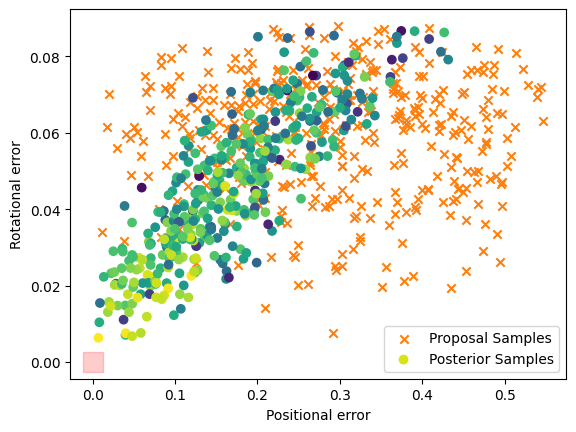

In [90]:
ws = normalize(ws)
cc = colormaps["viridis"](ws)[...,:3]



# ================
plt.figure()
plt.xlabel("Positional error")
plt.ylabel("Rotational error")
plt.scatter(0,0, c="r", marker="s", s=200, zorder=-1, alpha=0.2)
plt.scatter(dd_null, get_xq_errs(ps_null, cams[t1])[1], marker="x", c="C1", label="Proposal Samples")
# plt.scatter(*get_xq_errs(ps, cams[t1]), marker="o", c="C0", label="Posterior Samples")
# plt.scatter(*get_xq_errs(ps, cams[t1]), marker="o", c=cc, label="Posterior Samples")
plt.scatter(dd, get_xq_errs(ps, cams[t1])[1], marker="o", c=cc, label="Posterior Samples")
# plt.scatter(dd, get_xq_errs(ps, cams[t1])[1], marker=".", c="C0", label="Posterior Samples")
plt.legend()

In [91]:

rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)

for t in range(T):
    log_pose(f"true_pose_{t}", _cam0@cams[t], 
        c=jnp.array([.0,1.,1.]), 
        scale=.2, dims=np.array([.2,.2,.5]))


rr.log("Scale_Ambiguity_Line", rr.LineStrips3D(
    [[_cam0(b - (b-a)), _cam0(b + (b-a))]],
    colors=[255, 0, 0],
    radii=[0.003],

    ))

for i, (p,p0,c) in enumerate(zip(ps,ps_null,cc)):
    log_pose(f"xxx/p[{i}]", _cam0@p, 
    c = c, 
    scale=.05, dims=np.array([.1,.1,.75]))

    log_pose(f"yyy/p[{i}]", _cam0@p0, 
    c=jnp.array([0.,0.,1.]), 
    scale=.01, dims=np.array([.1,.1,.75]))


for i, (p,p0,c) in enumerate(zip(ps,ps_null,cc)):
    log_pose(f"xxx/p[{i}]", _cam0@p, 
    c = c, 
    scale=.05, dims=np.array([.1,.1,.75]))

    log_pose(f"yyy/p[{i}]", _cam0@p0, 
    c=jnp.array([0.,0.,1.]), 
    scale=.01, dims=np.array([.1,.1,.75]))



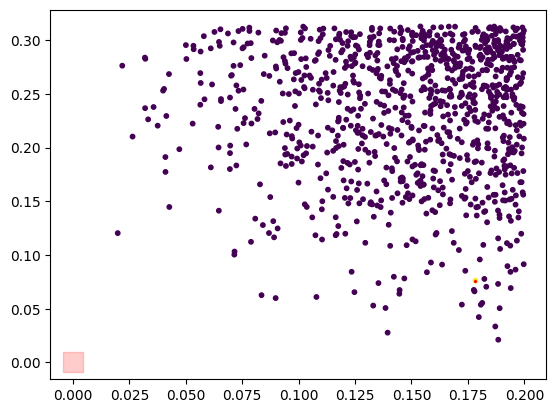

In [236]:

inferred_cam = cams[1]

plt.figure()
plt.scatter(0,0, c="r", marker="s", s=200, zorder=-1, alpha=0.2)


for i in range(1):

    key, keys = keysplit(key, 1, 1_000)
    test_cams = vmap_uniform_pose(keys, inferred_cam, 0.2, .2)

    obs_sig = jnp.array(1.)
    camera_mask = proposal_mask.any(0) & vis[1]
    ws = camera_score_approx(test_cams, ys[1], posterior_ws, proposed_xs, intr, obs_sig, camera_mask)

    perm = jnp.argsort(ws)

    ws = ws[perm] - logsumexp(ws)
    test_cams = test_cams[perm] 

    q_ds = jax.vmap(quat_diff, (0,None))(test_cams.quat, cams[1].quat)
    x_ds = jnp.linalg.norm(test_cams.pos - cams[1].pos[None], axis=-1)

    inferred_cam = test_cams[-1]

    k=4_000
    plt.scatter(x_ds[-k:], q_ds[-k:], c=jnp.exp(ws[-k:]), s=10, zorder=i)
    plt.scatter(x_ds[-1], q_ds[-1], c="r", marker="x", s=2, zorder=100)
    # plt.scatter(0,0, c="r", marker="d", s=10)

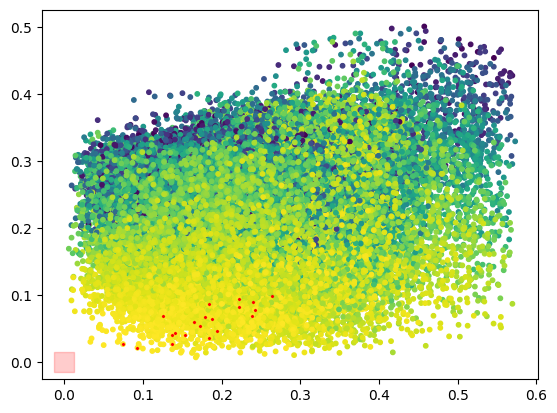

In [219]:

inferred_cam = cams[0]

plt.figure()
plt.scatter(0,0, c="r", marker="s", s=200, zorder=-1, alpha=0.2)


for i in range(20):

    key, keys = keysplit(key, 1, 5_000)
    test_cams = vmap_uniform_pose(keys, inferred_cam, 0.2, .2)

    obs_sig = jnp.array(1.)

    camera_mask = proposal_mask.any(0) & vis[1]
    ws = camera_score_approx(test_cams, ys[1], posterior_ws, proposed_xs, intr, obs_sig, camera_mask)

    perm = jnp.argsort(ws)

    ws = ws[perm]
    test_cams = test_cams[perm] 

    q_ds = jax.vmap(quat_diff, (0,None))(test_cams.quat, cams[1].quat)
    x_ds = jnp.linalg.norm(test_cams.pos - cams[1].pos[None], axis=-1)

    inferred_cam = test_cams[-1]

    k=4_000
    plt.scatter(x_ds[-k:], q_ds[-k:], c=ws[-k:], s=10, zorder=i)
    plt.scatter(x_ds[-1], q_ds[-1], c="r", marker="x", s=2, zorder=100)
    # plt.scatter(0,0, c="r", marker="d", s=10)

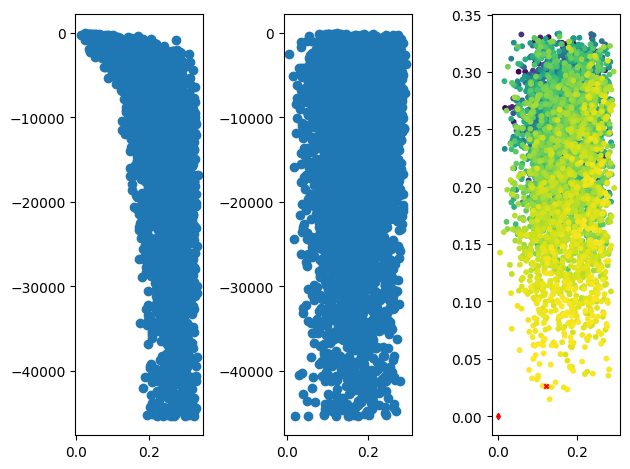

In [199]:
q_ds = jax.vmap(quat_diff, (0,None))(test_cams.quat, cams[1].quat)
x_ds = jnp.linalg.norm(test_cams.pos - cams[1].pos[None], axis=-1)

k = 4000

fig, axs = plt.subplots(1,3)
axs[0].scatter(q_ds[-k:], ws[-k:])
axs[1].scatter(x_ds[-k:], ws[-k:])
axs[2].scatter(x_ds[-k:], q_ds[-k:], c=ws[-k:], s=10)
axs[2].scatter(x_ds[-1], q_ds[-1], c="r", marker="x", s=10)
axs[2].scatter(0,0, c="r", marker="d", s=10)
fig.tight_layout()

In [156]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [157]:

rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)


log_pose(f"true_pose_0", _cam0@cams[0], 
    c=jnp.array([.0,1.,1.]), 
    scale=.2, dims=np.array([.2,.2,.5]))


log_pose(f"true_pose_1", _cam0@cams[1], 
    c=jnp.array([.0,1.,1.]), 
    scale=.2, dims=np.array([.2,.2,.5]))


ids = jnp.arange(test_cams.shape[0])[:100]
ws_ = ws[ids]
ws_ = normalize(ws_)
cc = colormaps["viridis"](ws_)[...,:3]

for i, (c, p) in enumerate(zip(cc, test_cams[ids])):
    log_pose(f"test_poses/p[{i}]", _cam0@p, 
    c = c, 
    scale=.05, dims=np.array([.18,.18,.75]))